In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os # makes you access your files on hard drive outside the folder
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, roc_curve, precision_score, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay

In [107]:
dfc = pd.read_csv('data/client_train.csv')
dfi = pd.read_csv('data/invoice_train.csv')

In [108]:
dfc['client_id'] = dfc['client_id'].apply(lambda x: x.replace('train_Client_', ''))
dfi['client_id'] = dfc['client_id'].apply(lambda x: x.replace('train_Client_', ''))

In [109]:
dfc.columns

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'target'],
      dtype='object')

In [110]:
# we check the values for certain columns and decider, wether we transform them to categorical or not.
dfi.tarif_type= dfi.tarif_type.astype('category')
#dfi.counter_type = dfi.counter_type.astype('category')
#dfi.counter_code = dfi.counter_code.astype('category')
dfi.reading_remarque = dfi.reading_remarque.astype('category')
dfc.region = dfc.region.astype('category')
dfc.disrict = dfc.disrict.astype('category')
dfc.client_catg = dfc.client_catg.astype('category')



# some columns can be reduced to int8, to save memory.
dfi.counter_coefficient = dfi.counter_coefficient.astype('int8')
dfi.months_number = dfi.months_number.astype('int16')

dfi.consommation_level_4 = dfi.consommation_level_4.astype('int32')
dfi.consommation_level_3 = dfi.consommation_level_3.astype('int32')
dfi.consommation_level_2 = dfi.consommation_level_2.astype('int32')
dfi.consommation_level_1 = dfi.consommation_level_1.astype('int32')

# dfi.counter_statue.value_counts()
dfi.counter_statue = dfi.counter_statue.astype('category')

In [111]:
dfi.drop(dfi[dfi['months_number'] > 48].index, axis=0, inplace=True)

list_erroneous_month_clients = dfi.query("months_number > 48").client_id.tolist() ### why? 

In [112]:
# we also want to get rid of the erroneous <0 month numbers
dfi.drop(dfi[dfi['months_number'] < 1].index, axis=0, inplace=True)


In [113]:
#Have to clean up the counter_statue column cause Decision tree gets upset converting the string to a float

#I'm wondering now if the 0s are actually all missing values, kinda

dfi.counter_statue.unique().tolist()
dfi.counter_statue.replace({'4' : 4, '5' : 5, '0' : 0, '1' : 1, 'A' : 6, 618 : 6, 420 : 6 }, inplace=True)

dfi.counter_type.replace({"ELEC":0,"GAZ":1}, inplace=True)
dfi.counter_statue.unique()

[0, 1, 5, 4, 3, 2, 6]
Categories (10, int64): [0, 1, 2, 3, ..., 46, 6, 769, 269375]

In [114]:
dfi.reading_remarque.value_counts()
dfi.reading_remarque.replace({413 : 7, 5 : 7}, inplace=True)

In [115]:
#Let's generate the avg monthly use column

dfi.eval('avg_month_use = (new_index - old_index) / months_number ', inplace=True)

In [116]:
x = dfc.drop('target', axis=1)  # split on the client id 
y = dfc['target']
#list_of_targets = dfc.query('target == 1').client_id.tolist()
#y = pd.Series(dfi.client_id.isin(list_of_targets))

In [117]:
X_train_client, X_test_client , y_train_client, y_test_client = train_test_split(x, y, stratify=y, random_state=42)

In [118]:
x_train_alt = pd.concat([X_train_client, dfi], axis=1, join='inner').drop(['creation_date', 'invoice_date', 'counter_number', 'old_index', 'new_index', 'months_number'], axis=1)
# might have to include invoice date for the regular descision tree

In [119]:
x_test_alt = pd.concat([X_test_client, dfi], join='inner', axis =1).drop(['creation_date', 'counter_number', 'invoice_date',  'old_index', 'new_index', 'months_number'], axis=1)
# might have to include invoice date for the regular descision tree  and 

In [120]:
y_train = pd.concat([y_train_client, dfi], join='inner', axis =1)['target']

In [121]:
y_test = pd.concat([y_test_client, dfi], join='inner', axis =1)['target']

In [122]:
x_train = x_train_alt.drop('client_id', axis=1)
x_test = x_test_alt.drop('client_id', axis=1)

tree = DecisionTreeClassifier(random_state=42, )
tree.fit(x_train, y_train)

y_train_pred = tree.predict(x_train)
y_test_pred = tree.predict(x_test)

In [123]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score

print(f'This is the classification report for our training data \n {classification_report(y_train, y_train_pred)}\n'
        f'the classification report for our testing data\n {classification_report(y_test, y_test_pred)}\n')

In [124]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

In [125]:
# for XGBoost we need to encode the data 

In [126]:
x_train.columns

Index(['disrict', 'client_catg', 'region', 'tarif_type', 'counter_statue',
       'counter_code', 'reading_remarque', 'counter_coefficient',
       'consommation_level_1', 'consommation_level_2', 'consommation_level_3',
       'consommation_level_4', 'counter_type', 'avg_month_use'],
      dtype='object')

In [127]:
#which columns to get dummies from 
dummies = ['disrict', 'client_catg', 'region', 'tarif_type', 'counter_statue', 'reading_remarque' ]


In [128]:
dummy_train = pd.get_dummies(x_train[dummies], dtype='int', drop_first=True)
dummy_train
x_train_final = pd.concat([dummy_train, x_train.drop(dummies, axis=1)], axis=1)


In [129]:
#x_train_final['invoice_date'] = pd.to_datetime(x_train_final['invoice_date'], format='%Y-%m-%d').astype(int)

In [130]:
dummy_test = pd.get_dummies(x_test[dummies], dtype='int', drop_first=True)
dummy_test
x_test_final = pd.concat([dummy_test, x_test.drop(dummies, axis=1)], axis=1)


In [131]:
#x_test_final['invoice_date'] = pd.to_datetime(x_test_final['invoice_date'], format='%Y-%m-%d').astype(int)

In [132]:
model1 = XGBClassifier(scale_pos_weight= len(y[y == 0]) / len(y[y == 1]) , max_delta_step=1)
model1.fit(x_train_final, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=None, max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, predictor=None,
              random_state=None, ...)

In [133]:
y_train_pred = model1.predict(x_train_final)
y_test_pred = model1.predict(x_test_final)

In [134]:
print(f'This is the classification report for our training data \n {classification_report(y_train, y_train_pred)}\n'
        f'the classification report for our testing data\n {classification_report(y_test, y_test_pred)}\n')

This is the classification report for our training data 
               precision    recall  f1-score   support

         0.0       0.97      0.70      0.81     95845
         1.0       0.11      0.66      0.20      5669

    accuracy                           0.70    101514
   macro avg       0.54      0.68      0.50    101514
weighted avg       0.92      0.70      0.78    101514

the classification report for our testing data
               precision    recall  f1-score   support

         0.0       0.95      0.69      0.80     31944
         1.0       0.08      0.43      0.13      1892

    accuracy                           0.67     33836
   macro avg       0.51      0.56      0.46     33836
weighted avg       0.90      0.67      0.76     33836




grid_params = {'max_depth': [5, 10, 15, 20 ,25, 30 , 45, 50 ], 
                'learning_rate':  [0.01 , 0.05, 0.1, 0.15, 0.2],
                'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
                'reg_alpha': [0, 0.0001, 0.005, 0.01, 0.05],
                #'reg_lambda': [0.1, 0.5, 1, 5, 10]
               }


#random_search = RandomizedSearchCV(estimator=XGBClassifier(scale_pos_weight= len(y[y == 0]) / len(y[y == 1]) , max_delta_step=1), 
                                    param_distributions=grid_params,
                                    scoring='recall', 
                                    verbose=3,
                                    n_jobs=-1)

In [135]:
#random_search.fit(x_train_final, y_train)

In [136]:
#best_params = random_search.best_params_

In [137]:
#print(f' these are the optimal parameters : {random_search.best_params_} \n resulting in an accuracy of: {random_search.best_score_}')

In [138]:
#model_best = XGBClassifier(**best_params)

In [139]:
#model_best.fit(x_train_final, y_train)
#y_train_pred = model_best.predict(x_train_final)
#y_test_pred = model_best.predict(x_test_final)

In [140]:
#print(f' the classification report for out training set with the best model {classification_report(y_train_pred, y_train_pred)}\n '
#      f' and the report on our Test data {classification_report(y_test, y_test_pred )}')

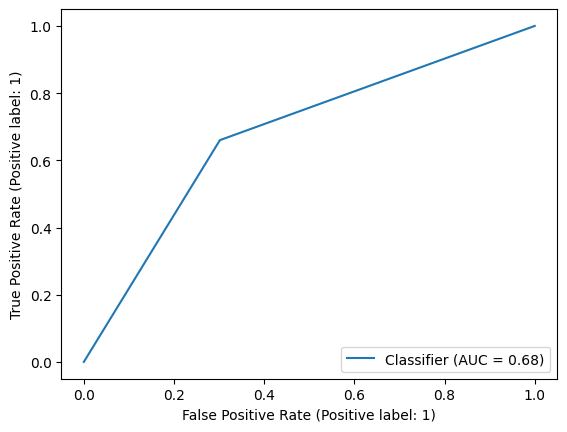

In [141]:
roc_curve(y_train, y_train_pred)
RocCurveDisplay.from_predictions(y_train,y_train_pred)

In [142]:
y_test_prob = model1.predict_proba(x_test_final)

y_test_prob

array([[0.43311727, 0.5668827 ],
       [0.5417167 , 0.4582833 ],
       [0.48558468, 0.5144153 ],
       ...,
       [0.5281838 , 0.4718162 ],
       [0.48558468, 0.5144153 ],
       [0.48921525, 0.51078475]], dtype=float32)

In [143]:
x_test_alt['predictions_1'] = y_test_prob[: , 1]

In [144]:
x_test_alt['tresh'] = x_test_alt['predictions_1'].apply(lambda x: 1 if x  >= 0.5 else 0)
x_test_alt

,disrict,client_id,client_catg,region,client_id,tarif_type,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,counter_type,avg_month_use,predictions_1,tresh
55911,69,28374,11,103,28374,11,0,203,6,1,369,0,0,0,0,92.25,0.566883,1
105078,69,72624,11,107,72624,11,0,203,9,1,633,0,0,0,0,158.25,0.458283,0
87970,69,57227,11,107,57227,11,0,203,6,1,305,0,0,0,0,76.25,0.514415,1
77202,69,47536,11,103,47536,40,0,5,6,1,105,0,0,0,1,26.25,0.591854,1
40801,69,14775,11,107,14775,11,0,207,6,1,533,0,0,0,0,133.25,0.502124,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129141,63,94281,11,311,94281,11,0,203,6,1,597,0,0,0,0,149.25,0.615704,1
16080,62,114469,11,309,114469,40,0,5,6,1,149,0,0,0,1,37.25,0.448996,0
81165,69,51101,11,104,51101,40,0,5,6,1,89,0,0,0,1,22.25,0.471816,0
55106,69,2765,11,107,2765,11,0,203,6,1,294,0,0,0,0,73.50,0.514415,1


In [145]:
dfi.query(f"index in {y_test.index.tolist()}")

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,avg_month_use
2,10,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,0,30.75
5,10000,2017-07-17,11,1335667,0,207,9,1,314,0,0,0,15638,15952,8,0,39.25
14,100008,2014-07-18,11,1335667,0,203,8,1,99,0,0,0,14384,14483,4,0,24.75
15,100009,2014-11-24,11,1335667,0,203,8,1,141,0,0,0,14483,14624,4,0,35.25
16,10001,2015-11-18,11,1335667,0,207,9,1,217,0,0,0,14849,15066,4,0,54.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135470,99979,2012-01-18,40,44518,0,5,6,1,257,0,0,0,5547,5804,4,1,64.25
135477,99985,2007-05-25,11,524033,0,207,6,1,746,0,0,0,37160,37906,4,0,186.50
135479,99987,2011-05-20,40,44518,0,5,6,1,372,0,0,0,5095,5467,4,1,93.00
135484,99991,2014-05-15,40,44518,0,5,6,1,277,0,0,0,7174,7451,4,1,69.25


In [146]:
from collections import Counter

In [147]:
#extract suspects from y_pred

test_clients = dfi.loc[y_test.index, 'client_id'].tolist() # get all clients included in y_test

y_pred_indexed = pd.DataFrame({'y_pred' : y_test_pred, 'client_id' : test_clients}, index=y_test.index) # assign row indexes of test data to y_pred

#pred_suspects = y_pred_indexed.query("y_pred == True").client_id.tolist()
#better line suggested by Bito:

pred_suspects = y_pred_indexed[y_pred_indexed["y_pred"] == True]["client_id"].values

#We can also count how many flagged invoices we get for each client, in case we want to change this threshold


num_flagged_invoices = Counter(pred_suspects)



In [148]:
#compare to list of true suspects

dfc_test_clients = dfc[dfc["client_id"].isin(set(test_clients))] # get subset of client df with clients in test set

dfc_test_clients["num_flags"] = dfc_test_clients["client_id"].map(num_flagged_invoices)

#calculate recall and precision

In [149]:
#Add predictions columns based on different thresholds

dfc_test_clients.eval("thresh_1 = num_flags >= 1", inplace=True)
dfc_test_clients.eval("thresh_2 = num_flags >= 2", inplace=True)

In [150]:
y_true = dfc_test_clients.target.values
y_pred_thresh1 = dfc_test_clients.thresh_1.values
y_pred_thresh2 = dfc_test_clients.thresh_2.values
y_pred_thresh1

array([False,  True, False, ..., False,  True, False])

In [151]:
print("Recall score threshold 1: {}%".format(round(recall_score(y_true,y_pred_thresh1) * 100, 2)))

print("Precision score threshold 1: {}%".format(round(precision_score(y_true,y_pred_thresh1) * 100, 2)))

print("Recall score threshold 2: {}%".format(round(recall_score(y_true,y_pred_thresh2) * 100, 2)))

print("Precision score threshold 2: {}%".format(round(precision_score(y_true,y_pred_thresh2) * 100, 2)))

Recall score threshold 1: 43.13%
Precision score threshold 1: 7.51%
Recall score threshold 2: 0.0%
Precision score threshold 2: 0.0%


Text(0.5, 1.0, 'ROC for threshold = 1 flagged invoice')

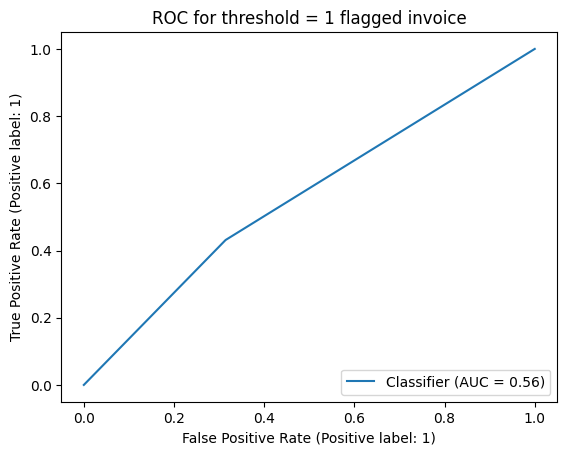

In [152]:
RocCurveDisplay.from_predictions(y_true,y_pred_thresh1)
plt.title("ROC for threshold = 1 flagged invoice")

In [153]:
model1.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': 1,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 16.9081416864922,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

## Feature Importance ##

Shap allows feature importance analysis.

import shap    for unindentified reasons it does not work 

<Axes: >

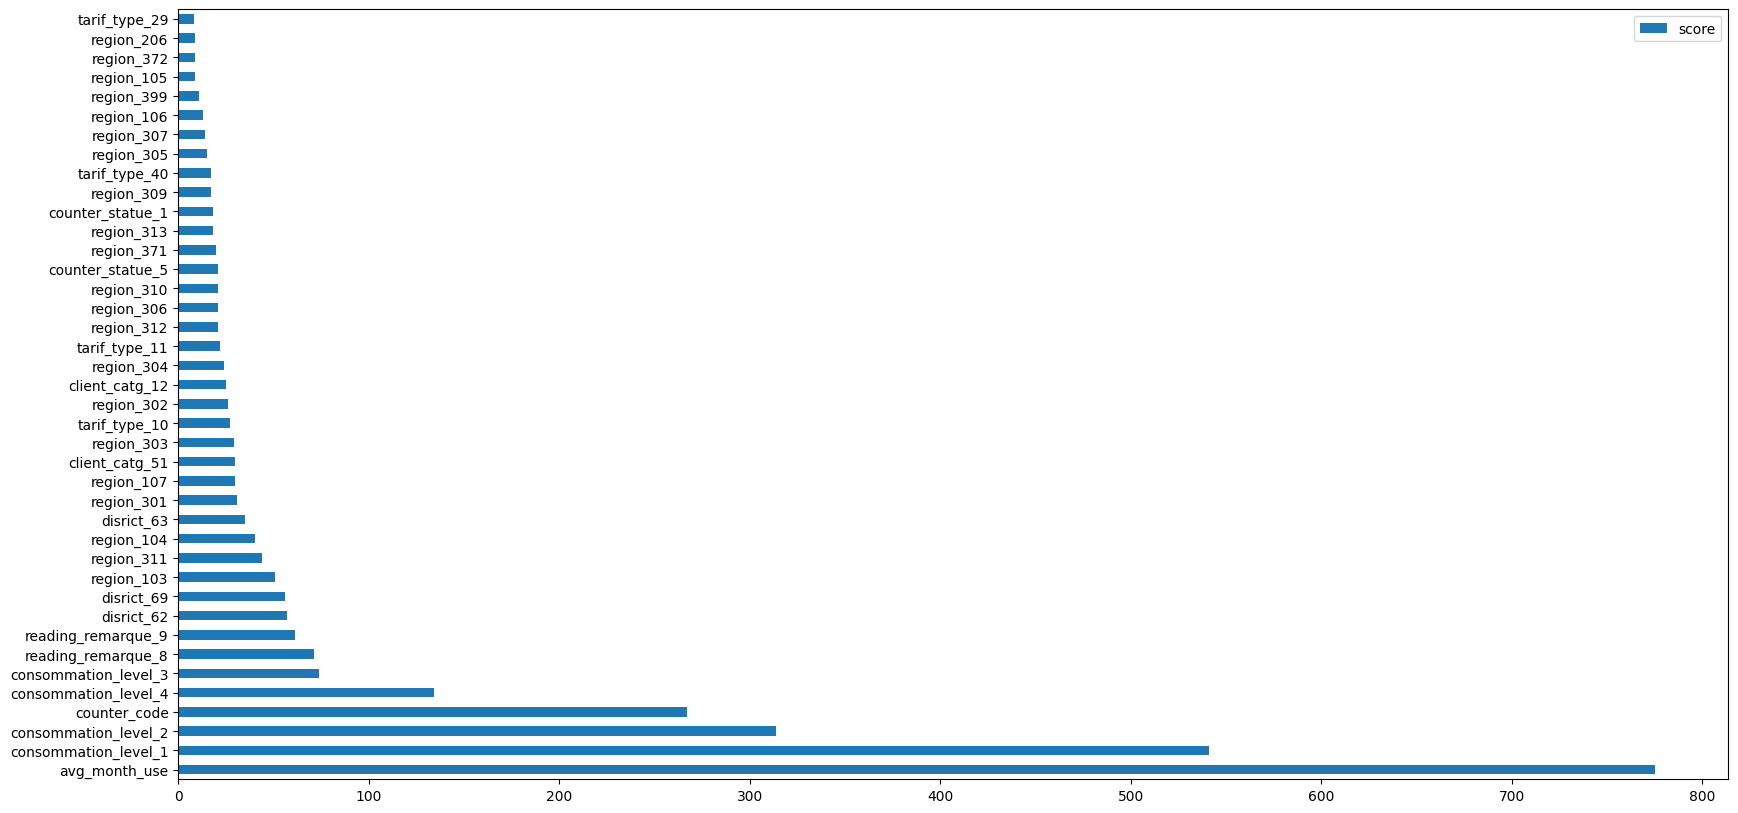

In [155]:
feature_important = model1.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [ ]:
model1.feature_importances_

array([0.02653744, 0.02274574, 0.02877468, 0.02085043, 0.06405251,
       0.0519322 , 0.01047365, 0.0124903 , 0.01450338, 0.02065372,
       0.        , 0.00831589, 0.04758226, 0.0160495 , 0.01390376,
       0.01577979, 0.01700515, 0.01709988, 0.01537711, 0.02987101,
       0.02609286, 0.01550234, 0.03944467, 0.0175306 , 0.01662498,
       0.02208222, 0.01827987, 0.01546666, 0.01802215, 0.01176476,
       0.02208776, 0.01487899, 0.0195709 , 0.01367062, 0.01272341,
       0.01250566, 0.        , 0.        , 0.        , 0.        ,
       0.01699627, 0.        , 0.01412804, 0.        , 0.01435112,
       0.01757078, 0.        , 0.01333451, 0.00729097, 0.01524652,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01350644, 0.01290533, 0.        , 0.        , 0.01616633,
       0.01669472, 0.01483198, 0.        , 0.01623938, 0.01424952,
       0.01639996, 0.01320906, 0.        , 0.01663232], dtype=float32)